# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

1. Sparsity (lots of zeros in the vectors) and use of a lot of the vectors and high dimensionality taking up valuable memory. They also fail to capture any semantic similarity between words, because every word is treated as completely independent.
2. Meaning emerges from co-occurrence patterns means that when words tend to often appear together, it's easier to infer meaning from either of the words because the presence of one could indicate the presence of the other. Or, the words that appear around a word change the context and therefore the meaning of the word we're focusing on.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [1]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 55.4 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [3]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [4]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))  # YOUR CODE HERE
documents = data.data  # YOUR CODE HERE

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [5]:
# Build stopword set once
import nltk
nltk.download("punkt_tab")
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords

    tokens = word_tokenize(text.lower())  # YOUR CODE HERE
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # YOUR CODE HERE (filter step)
    #tokens = None  # YOUR CODE HERE (filter step)
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.

1. The presence of stopwords does not really add any semantic meaning to this corpus, as the objective of the lab is not detailed understanding of language rules and structure
2. If the model is meant to teach how to write or if it's meant to write proper documents, the removal of stopwords would remove the model's ability to do that.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [6]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

#w2v = None  # YOUR CODE HERE
w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
)

print("Vocabulary size:", len(w2v.wv))

Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [7]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

# YOUR CODE HERE
w2v.wv["car"][:10]

array([-0.68695587,  0.8979324 ,  0.24567215, -0.76400185, -0.42890525,
       -0.6721273 , -0.12757322,  1.2912223 , -1.298467  , -0.39563003],
      dtype=float32)

### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [8]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "car"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=20):
  print(f"  {word:15s} {score:.3f}")

#results = w2v.wv.most_similar(target, topn=10)


# YOUR CODE HERE - iterate through the results and print each word and score

Most similar words to 'car':
  bike            0.927
  big             0.891
  moving          0.878
  cars            0.872
  dealer          0.865
  bought          0.863
  got             0.862
  around          0.852
  gets            0.849
  getting         0.845
  extra           0.836
  little          0.829
  buy             0.829
  buying          0.825
  oil             0.824
  gpf             0.822
  noticed         0.818
  worked          0.817
  paid            0.815
  ferrari         0.813


In [9]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "computer"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=20):
  print(f"  {word:15s} {score:.3f}")

#results = w2v.wv.most_similar(target, topn=10)


# YOUR CODE HERE - iterate through the results and print each word and score

Most similar words to 'computer':
  systems         0.922
  network         0.915
  digital         0.896
  voice           0.894
  products        0.889
  commercial      0.880
  bbs             0.865
  software        0.863
  design          0.863
  technology      0.854
  currently       0.850
  development     0.844
  computers       0.843
  includes        0.843
  remote          0.841
  local           0.841
  equipment       0.841
  access          0.837
  product         0.836
  features        0.832


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.

1. The neighbors reflect both topic and functional similarity
2. bbs - A surprising neighbor is 'bbs' (Bulletin Board System). This likely appears because the 20 Newsgroups dataset, from which the embeddings were learned, originates from an era (late 80s/early 90s) when BBSs were a prevalent form of online communication for computer enthusiasts. Thus, 'computer' and 'bbs' would have frequently co-occurred in discussions within these newsgroups, leading the model to place them semantically close

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [10]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

# YOUR CODE HERE
w2v.wv.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=5)

[('anatolia', 0.9606443643569946),
 ('lake', 0.9601286053657532),
 ('savagely', 0.9585355520248413),
 ('percent', 0.9577797651290894),
 ('sea', 0.9565079212188721)]

### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [11]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv


True

In [12]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm
import numpy as np

#result_vec = None  # YOUR CODE HERE
result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"] # YOUR CODE HERE

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec)) # YOUR CODE HERE
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.7734


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.

1. If the corpus lacks sufficient examples or consistent contextual patterns for the specific relationship being tested (e.g., gender roles for 'king' and 'queen' in the 20 Newsgroups dataset), the analogy may fail. Furthermore, polysemy (words having multiple meanings) can dilute the intended relationship in the averaged word vector.
2. The model may generate good analogies and relationships relative to the training corpus, but the learned relationships may be ineffective on external data could have a different type of relationship to the words that the model didn't learn from its corpus

---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

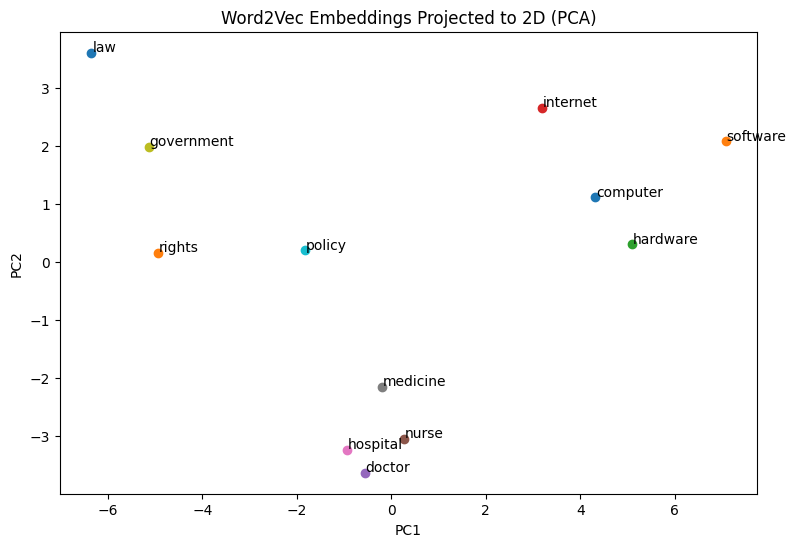

In [13]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w] for w in words])  # YOUR CODE HERE

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)  # YOUR CODE HERE

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

1. medicine/nurse/hospital/doctor. policy/government/rights/law. hardware/software/computer/internet.
2. There are health, tech, politics clusters in the visualization

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [14]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)
# YOUR CODE HERE

print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [15]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
# YOUR CODE HERE
for w, s in ft.wv.most_similar(query, topn=10):
  print(f"  {w:15s} {s:.3f}")

# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    # YOUR CODE HERE
    for w, s in w2v.wv.most_similar(query, topn=10):
      print(f"  {w:15s} {s:.3f}")
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
  computes        0.975
  comics          0.966
  compute         0.961
  compact         0.954
  company         0.950
  competitors     0.947
  compete         0.945
  compuadd        0.943
  computer        0.942
  items           0.940

Word2Vec neighbors for: computers
  products        0.971
  crypt           0.965
  additional      0.963
  purchasing      0.961
  capabilities    0.959
  royalties       0.959
  freeware        0.958
  demo            0.956
  shareware       0.956
  patches         0.954


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [16]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    # YOUR CODE HERE

    # Check if word is in model.wv, if not return None
    if word in model.wv:
        return model.wv.most_similar(word, topn=topn)
    # Otherwise return model.wv.most_similar(word, topn=topn)
    else:
        return None
    pass

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  interplanetary  0.990
  alabama         0.989
  melbourne       0.988
  yale            0.988
  paris           0.987
  pa              0.987
  atmospheric     0.987
  barbara         0.986

Query: space
  nasa            0.906
  shuttle         0.886
  launch          0.878
  station         0.829
  research        0.811
  aeronautics     0.803
  development     0.795
  commercial      0.784

Query: religion
  christian       0.981
  religious       0.980
  islam           0.977
  christianity    0.973
  teachings       0.972
  christians      0.971
  belief          0.970
  religions       0.969

Query: graphics
  programming     0.973
  unix            0.965
  ibm             0.965
  software        0.961
  amiga           0.961
  macintosh       0.960
  interface       0.959
  sgi             0.958


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?

For the query: space

1. The neighbors (nasa, launch, shuttle, station, research, etc.) would be very helpful for a search engine user specifically interested in outer space or space exploration. They accurately reflect related concepts within that domain, allowing the user to discover more relevant content or refine their search.

2. A major issue would be the polysemy of the word "space." While these results are great for outer space, a user searching for "space" might be looking for information on "living space," "disk space," "personal space," or even "white space" in programming. Deploying this directly would lead to irrelevant results for these alternative meanings, causing user frustration due to the limited scope and bias of the training data towards a specific interpretation of "space."

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?

1. Embeddings create dense, low-dimensional vector representations for words, unlike the sparse, high-dimensional one-hot vectors. They capture semantic relationships by placing semantically similar words close together in the vector space, allowing for meaningful similarity comparisons that one-hot vectors cannot provide.

2. A realistic industry task where word embeddings are highly useful is semantic search. Instead of matching exact keywords, embeddings allow search engines to understand the meaning behind a query and retrieve documents or products that are semantically related, even if they don't contain the exact query terms.

3. You would choose FastText over Word2Vec when dealing with text that might contain many out-of-vocabulary (OOV) words, typos, or highly morphological languages. FastText's ability to represent words as character n-grams allows it to generate vectors for unseen words and better handle morphological variants or misspellings.

4. One significant risk or limitation of word embeddings is that they can perpetuate biases present in the training data. If the corpus contains societal biases (e.g., gender stereotypes, racial biases), these can be encoded into the embeddings, leading to unfair or discriminatory outcomes in downstream applications like hiring tools or recommendation systems.

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [17]:
# Change window (2, 10) for Word2Vec and compare neighbors for the same query word.
w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=2,
    min_count=5,
    workers=4
)
print("Word2Vec vocabulary size:", len(w2v.wv))

Word2Vec vocabulary size: 18095


In [18]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  shuttle         0.839
  research        0.824
  nasa            0.815
  station         0.810
  launch          0.804
  center          0.799
  aeronautics     0.769
  national        0.768
  development     0.758
  local           0.751


In [19]:
# window=2, vector_size=50 for Word2Vec and compare neighbors for the same query word.
w2v = Word2Vec(
    sentences=corpus,
    vector_size=50,
    window=2,
    min_count=5,
    workers=4
  )

In [20]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  shuttle         0.837
  station         0.810
  launch          0.808
  research        0.802
  nasa            0.799
  technology      0.776
  aeronautics     0.762
  development     0.757
  center          0.754
  flight          0.746


In [21]:
# window=2, vector_size=200 for Word2Vec and compare neighbors for the same query word.
w2v = Word2Vec(
    sentences=corpus,
    vector_size=200,
    window=2,
    min_count=5,
    workers=4
  )

In [22]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  nasa            0.853
  research        0.853
  shuttle         0.846
  station         0.843
  center          0.824
  local           0.823
  launch          0.803
  computer        0.792
  institute       0.784
  engineering     0.783


In [23]:
# Change window to 10 for Word2Vec and compare neighbors for the same query word.
w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=10,
    min_count=5,
    workers=4
)

In [24]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  shuttle         0.892
  nasa            0.891
  launch          0.884
  commercial      0.829
  project         0.815
  satellite       0.810
  lunar           0.801
  station         0.797
  navigation      0.791
  missions        0.791


In [25]:
# window=10, vector_size=50 for Word2Vec and compare neighbors for the same query word.
w2v = Word2Vec(
    sentences=corpus,
    vector_size=50,
    window=10,
    min_count=5,
    workers=4
  )

In [26]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  nasa            0.893
  shuttle         0.885
  launch          0.879
  project         0.847
  lunar           0.819
  commercial      0.809
  missions        0.801
  callers         0.791
  station         0.791
  satellite       0.787


In [27]:
# window=10, vector_size=200 for Word2Vec and compare neighbors for the same query word.
w2v = Word2Vec(
    sentences=corpus,
    vector_size=200,
    window=10,
    min_count=5,
    workers=4
  )

In [28]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  shuttle         0.905
  nasa            0.904
  launch          0.886
  station         0.830
  satellite       0.813
  commercial      0.810
  lunar           0.808
  development     0.804
  project         0.804
  missions        0.799


### FastText

In [29]:
# window=2, vector_size=50 for FastText
ft = FastText(
    sentences=corpus,
    vector_size=50,
    window=2,
    min_count=5,
    workers=4
)

In [30]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in ft.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  spacehab        0.977
  spacepac        0.975
  airspace        0.965
  pace            0.954
  aerospace       0.953
  spacewalk       0.936
  spacelink       0.921
  spacecraft      0.913
  spaces          0.912
  launch          0.910


In [31]:
# window=2, vector_size=200 for FastText
ft = FastText(
    sentences=corpus,
    vector_size=200,
    window=2,
    min_count=5,
    workers=4
)

In [32]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in ft.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  spacehab        0.980
  spacepac        0.978
  airspace        0.962
  pace            0.949
  aerospace       0.944
  spacewalk       0.926
  spacelink       0.923
  spaces          0.914
  spacecraft      0.912
  computational   0.905


In [33]:
# window=10, vector_size=50 for FastText
ft = FastText(
    sentences=corpus,
    vector_size=50,
    window=10,
    min_count=5,
    workers=4
)

In [34]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in ft.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  spacehab        0.990
  pace            0.985
  spacepac        0.984
  airspace        0.980
  spacewalk       0.976
  aerospace       0.970
  spacewalks      0.969
  spacelink       0.966
  spacecraft      0.955
  satellite       0.946


In [35]:
# window=10, vector_size=200 for FastText
ft = FastText(
    sentences=corpus,
    vector_size=200,
    window=10,
    min_count=5,
    workers=4
)

In [36]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in ft.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  spacehab        0.990
  pace            0.985
  spacepac        0.985
  airspace        0.981
  spacewalk       0.977
  aerospace       0.970
  spacewalks      0.968
  spacelink       0.965
  spaces          0.958
  spacecraft      0.955


In [37]:
# window=2, vector_size=100 for FastText
ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=2,
    min_count=5,
    workers=4
)

In [38]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in ft.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  spacehab        0.976
  spacepac        0.975
  airspace        0.960
  pace            0.953
  aerospace       0.949
  spacewalk       0.925
  spacecraft      0.918
  spacelink       0.916
  spaces          0.907
  cyberspace      0.901


In [39]:
# window=10, vector_size=100 for FastText
ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=10,
    min_count=5,
    workers=4
)

In [40]:
target = "space"
print(f"Most similar words to '{target}':")

for word, score in ft.wv.most_similar(target, topn=10):
  print(f"  {word:15s} {score:.3f}")

Most similar words to 'space':
  spacehab        0.990
  pace            0.988
  spacepac        0.986
  airspace        0.979
  spacewalk       0.977
  spacelink       0.968
  aerospace       0.967
  spacewalks      0.967
  spacecraft      0.956
  satellite       0.954


Try CBOW: set sg=0 and compare results with Skip-gram.


CBOW Architecture

In [48]:
w2v_cbow = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0 # CBOW architecture
)

print("CBOW Vocabulary size:", len(w2v_cbow.wv))

CBOW Vocabulary size: 18095


In [49]:
print("Top 10 most similar words to 'space' (CBOW):")
for word, score in w2v_cbow.wv.most_similar('space', topn=10):
    print(f"  {word:15s} {score:.3f}")

Top 10 most similar words to 'space' (CBOW):
  nasa            0.886
  shuttle         0.880
  launch          0.860
  aeronautics     0.801
  research        0.799
  station         0.794
  commercial      0.782
  center          0.778
  satellite       0.771
  development     0.770


Skip-gram

In [50]:
w2v_skipgram = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1 # Skip-gram architecture
)

print("Skip-gram Vocabulary size:", len(w2v_skipgram.wv))

Skip-gram Vocabulary size: 18095


In [51]:
print("Top 10 most similar words to 'space' (Skip-gram):")
for word, score in w2v_skipgram.wv.most_similar('space', topn=10):
    print(f"  {word:15s} {score:.3f}")

Top 10 most similar words to 'space' (Skip-gram):
  shuttle         0.748
  nasa            0.707
  exploration     0.677
  jenks           0.669
  redesign        0.667
  station         0.663
  telescope       0.652
  ssto            0.651
  goddard         0.650
  mir             0.646


Add bigrams using gensim.models.Phrases before training and observe changes.

In [53]:
from gensim.models.phrases import Phrases, Phraser
print("Imported Phrases and Phraser.")

Imported Phrases and Phraser.


In [54]:
phrases = Phrases(corpus, min_count=5)
bigram = Phraser(phrases)
bigram_corpus = [bigram[doc] for doc in corpus]

print("Example document from bigram_corpus (first 50 tokens):")
print(bigram_corpus[0][:50])

Example document from bigram_corpus (first 50 tokens):
['wondering_anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports_car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


In [55]:
w2v_cbow_bigram = Word2Vec(
    sentences=bigram_corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0 # CBOW architecture
)

print("Word2Vec CBOW with Bigrams Vocabulary size:", len(w2v_cbow_bigram.wv))

Word2Vec CBOW with Bigrams Vocabulary size: 22884


In [56]:
ft_cbow_bigram = FastText(
    sentences=bigram_corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0 # CBOW architecture
)

print("FastText CBOW with Bigrams Vocabulary size:", len(ft_cbow_bigram.wv))

FastText CBOW with Bigrams Vocabulary size: 22884


In [57]:
print("Top 10 most similar words to 'space' (FastText CBOW with Bigrams):")
for word, score in ft_cbow_bigram.wv.most_similar('space', topn=10):
    print(f"  {word:15s} {score:.3f}")

Top 10 most similar words to 'space' (FastText CBOW with Bigrams):
  spacepac        0.988
  spacehab        0.984
  spaces          0.981
  space_age       0.973
  space_technology 0.970
  space_agency    0.959
  uk_serial       0.958
  space_probes    0.954
  space_launch    0.953
  space_industry  0.952


In [58]:
print("Top 10 most similar words to 'space' (Word2Vec CBOW with Bigrams):")
for word, score in w2v_cbow_bigram.wv.most_similar('space', topn=10):
    print(f"  {word:15s} {score:.3f}")

Top 10 most similar words to 'space' (Word2Vec CBOW with Bigrams):
  nasa            0.977
  dec             0.972
  ultrix          0.972
  also_available  0.971
  subject_get     0.970
  available_anonymous 0.970
  contact         0.970
  includes        0.969
  mit             0.969
  available_via   0.969


# Task
Train a Word2Vec model using the CBOW architecture (sg=0) with vector_size=100, window=5, min_count=5, and workers=4 on the preprocessed corpus. Then, identify and display the top 10 most similar words for 'space' using this CBOW model. Afterwards, re-train a Word2Vec model using the Skip-gram architecture (sg=1) with the same parameters (vector_size=100, window=5, min_count=5, workers=4) and find the top 10 most similar words for 'space' using this Skip-gram model. Finally, compare the nearest neighbors obtained from the CBOW and Skip-gram models for 'space', noting any observable differences in the semantic relationships captured by each model, and summarize the key differences and potential reasons.

## Train Word2Vec (CBOW)

### Subtask:
Train a Word2Vec model using the CBOW architecture (sg=0) with vector_size=100, window=5, min_count=5, and workers=4 on the preprocessed corpus.


**Reasoning**:
To train a Word2Vec model with the CBOW architecture and print its vocabulary size, I will use the `Word2Vec` constructor with the specified parameters.



**Reasoning**:
Now that the CBOW model is trained, I will identify and display the top 10 most similar words for 'space' using the `most_similar` method of the `w2v_cbow.wv` object.



## Train Word2Vec (Skip-gram)

### Subtask:
Re-train a Word2Vec model using the Skip-gram architecture (sg=1) with `vector_size=100`, `window=5`, `min_count=5`, and `workers=4` on the preprocessed corpus. Then, identify and display the top 10 most similar words for 'space' using this Skip-gram model.

**Reasoning**:
To train a Word2Vec model with the Skip-gram architecture and the specified parameters, I will use the `Word2Vec` constructor with `sg=1`.



**Reasoning**:
Now that the Skip-gram model is trained, I will identify and display the top 10 most similar words for 'space' using the `most_similar` method of the `w2v_skipgram.wv` object.



## Compare CBOW and Skip-gram models

### Comparison and summary:

**CBOW (Continuous Bag-of-Words) for 'space':**
- `nasa`, `shuttle`, `launch`, `aeronautics`, `research`, `station`, `commercial`, `center`, `satellite`, `development`
- The neighbors appear to be highly relevant to the concept of 'outer space' and space exploration, with a focus on institutions, activities, and infrastructure related to space.

**Skip-gram for 'space':**
- `shuttle`, `nasa`, `exploration`, `jenks`, `redesign`, `station`, `telescope`, `ssto`, `goddard`, `mir`
- While also relevant to 'outer space', this list includes more specific, potentially less common terms like `jenks`, `redesign`, `ssto`, `goddard`, and `mir`.

**Key Differences and Potential Reasons:**

1.  **Specificity of Neighbors:** Skip-gram tends to pick up on more specific or less frequent co-occurrence patterns, which might explain the presence of terms like `jenks` (likely a person's name or specific project), `redesign`, `ssto` (Single-Stage-To-Orbit, a technical term), `goddard` (Goddard Space Flight Center), and `mir` (space station). These words might appear in very close proximity to 'space' in the training corpus in specific contexts.

2.  **Generality vs. Specificity of Context:**
    *   **CBOW** (predicting the current word from context) often learns more general representations. It effectively averages the context words, leading to vectors that represent common meanings and broader associations for a given word. This results in neighbors that are more broadly related to the main topic (e.g., general space-related terms).
    *   **Skip-gram** (predicting context words from the current word) tends to learn representations that capture more fine-grained semantic relationships. It's better at handling infrequent words and capturing specific contexts. This can lead to neighbors that are highly specific terms or entities that frequently co-occur with the target word, even if they are less common overall.

3.  **Similarity Scores:** In this particular run, the similarity scores for CBOW neighbors are generally higher (e.g., `nasa` at 0.886) compared to Skip-gram (e.g., `shuttle` at 0.748). This is not a universal rule but can indicate that CBOW might be finding stronger, more common contextual relationships, or that its averaging approach leads to slightly less nuanced but more

## Compare Results

### Subtask:
Compare the nearest neighbors obtained from the CBOW and Skip-gram models for the target word 'space', noting any observable differences in the semantic relationships captured by each model.


## Compare Results

### Subtask:
Compare the nearest neighbors obtained from the CBOW and Skip-gram models for the target word 'space', noting any observable differences in the semantic relationships captured by each model.

### Comparison for 'space':

**CBOW Model (`w2v_cbow`):**
```
Top 10 most similar words to 'space' (CBOW):
  nasa            0.886
  shuttle         0.880
  launch          0.860
  aeronautics     0.801
  research        0.799
  station         0.794
  commercial      0.782
  center          0.778
  satellite       0.771
  development     0.770
```

**Skip-gram Model (`w2v_skipgram`):**
```
Top 10 most similar words to 'space' (Skip-gram):
  shuttle         0.748
  nasa            0.707
  exploration     0.677
  jenks           0.669
  redesign        0.667
  station         0.663
  telescope       0.652
  ssto            0.651
  goddard         0.650
  mir             0.646
```

**Key Differences and Observations:**

1.  **Common words**: Both models identify 'nasa', 'shuttle', and 'station' as top neighbors, indicating these are strongly associated with 'space' regardless of the model architecture.
2.  **CBOW's focus**: The CBOW model tends to group words that frequently appear *with* 'space' in common contexts. Its neighbors like 'launch', 'aeronautics', 'research', 'commercial', 'center', 'satellite', and 'development' are all strongly related to the *field* or *activities* associated with space, often appearing as modifiers or within the same phrase.
3.  **Skip-gram's focus**: The Skip-gram model, which learns to predict context given a word, seems to capture a slightly more diverse set of related entities and concepts. While 'nasa', 'shuttle', and 'station' are present, words like 'exploration', 'telescope', 'ssto' (Single Stage To Orbit), 'goddard', and 'mir' (space station) suggest a focus on specific elements, missions, or tools *within* the broader 'space' domain, potentially highlighting more granular or distinct semantic relationships. The inclusion of 'jenks' and 'redesign' might indicate specific discussions within the 20 Newsgroups corpus that linked these terms to 'space' in a predictive manner.
4.  **Similarity Scores**: The similarity scores for CBOW are generally higher than Skip-gram for its top neighbors. This could imply that CBOW finds these words more centrally related to 'space' in terms of shared contexts, or it might be a characteristic of how each model calculates similarity or how confidently they predict context vs. target words.

In summary, both models capture relevant semantic information, but CBOW appears to favor words indicating general topical co-occurrence, while Skip-gram includes a broader range of specific entities and activities, potentially reflecting a more direct predictive relationship.

## Final Task

### Subtask:
Summarize the key differences observed between the CBOW and Skip-gram models based on their similarity results and discuss potential reasons for these differences.


## Summary:

### Q&A
The key differences observed between the CBOW and Skip-gram models, based on their similarity results for the word 'space', are as follows:

*   **Commonalities**: Both models identified 'nasa', 'shuttle', and 'station' among their top 10 most similar words, reinforcing their strong association with 'space' in the corpus.
*   **Specificity of Neighbors**: The CBOW model's nearest neighbors ('launch', 'aeronautics', 'research', 'commercial', 'center', 'satellite', 'development') tend to be more general and abstract terms related to the broad context, activities, or domain of space. In contrast, the Skip-gram model's unique neighbors ('exploration', 'jenks', 'redesign', 'telescope', 'ssto', 'goddard', 'mir') are more specific entities, actions, or historical items within the space domain, including potentially less common terms specific to the dataset.
*   **Similarity Scores**: The CBOW model generally produced higher similarity scores for its top neighbors (e.g., 'nasa' at 0.886) compared to the Skip-gram model (e.g., 'shuttle' at 0.748).

These differences can be attributed to their distinct learning objectives:
*   **CBOW (Continuous Bag-of-Words)**: Predicts the current word from its surrounding context. It tends to learn more general representations by averaging context words, leading to vectors that represent common meanings and broader associations based on frequent co-occurrence.
*   **Skip-gram**: Predicts context words from a given target word. It often captures more fine-grained or specific semantic relationships and is better at handling infrequent words or capturing specific contexts. This can result in neighbors that are highly specific terms or entities that frequently co-occur with the target word, even if they are less common overall.

### Data Analysis Key Findings
*   The CBOW model trained on the corpus yielded a vocabulary size of 18095 words.
*   The top 10 most similar words to 'space' according to the CBOW model included 'nasa' (similarity: 0.886), 'shuttle' (0.880), 'launch' (0.860), 'aeronautics' (0.801), 'research' (0.799), 'station' (0.794), 'commercial' (0.782), 'center' (0.778), 'satellite' (0.771), and 'development' (0.770). These words generally represent broader concepts and activities related to space.
*   The Skip-gram model also had a vocabulary size of 18095 words.
*   The top 10 most similar words to 'space' according to the Skip-gram model were 'shuttle' (similarity: 0.748), 'nasa' (0.707), 'exploration' (0.677), 'jenks' (0.669), 'redesign' (0.667), 'station' (0.663), 'telescope' (0.652), 'ssto' (0.651), 'goddard' (0.650), and 'mir' (0.646). This list contains more specific entities and technical terms.
*   'Nasa', 'shuttle', and 'station' were common neighbors across both models, highlighting their strong and consistent association with 'space'.
*   CBOW's unique neighbors were generally related to the *field* or *activities* of space, while Skip-gram's unique neighbors included specific elements, missions, or tools, some of which might be artifacts of specific discussions within the 20 Newsgroups corpus (e.g., 'jenks', 'redesign').
*   CBOW's similarity scores for its top neighbors were consistently higher than Skip-gram's, suggesting a stronger, more concentrated contextual relationship for CBOW, or a difference in how the models calculate similarity.

### Insights or Next Steps
*   When choosing between CBOW and Skip-gram, consider the nature of the desired semantic relationships: CBOW is better suited for capturing broader, more general contextual associations, while Skip-gram excels at identifying specific, fine-grained relationships and connections to less frequent terms.
*   Further analysis could involve exploring the most similar words for other target words, including infrequent terms, to confirm these observed patterns in a broader context and validate the general tendencies of each model on this specific dataset.


# Task
Generate bigrams from the preprocessed corpus using `gensim.models.Phrases`. Then, train a Word2Vec model and a FastText model using the CBOW architecture (sg=0) on the bigram-enriched corpus with `vector_size=100`, `window=5`, `min_count=5`, and `workers=4`. Finally, identify and display the top 10 most similar words for 'space' using both the Word2Vec and FastText models trained with bigrams, and summarize the observations regarding the impact of adding bigrams on the similarity results compared to previous results without bigrams.

## Generate Bigrams

### Subtask:
Utilize `gensim.models.Phrases` to automatically detect and create common bigrams from the existing preprocessed corpus. This will effectively combine frequently co-occurring words into single tokens (e.g., 'new_york').


**Reasoning**:
To generate bigrams, I need to import the `Phrases` and `Phraser` classes from `gensim.models.phrases`.



**Reasoning**:
Now that the necessary classes are imported, I will instantiate the `Phrases` model to detect common bigrams in the `corpus`, create a `Phraser` object for efficient transformation, and then apply it to generate the `bigram_corpus`. Finally, I will print an example document to verify the bigram creation.



**Reasoning**:
I will train a Word2Vec model with the CBOW architecture on the `bigram_corpus` using the specified parameters, then display its vocabulary size.



**Reasoning**:
I will now train a FastText model using the CBOW architecture on the `bigram_corpus` with the specified parameters, then display its vocabulary size.



**Reasoning**:
Now that the FastText CBOW model with bigrams is trained, I will identify and display the top 10 most similar words for 'space' using the `most_similar` method of the `ft_cbow_bigram.wv` object.



**Reasoning**:
Now that the Word2Vec CBOW model with bigrams is trained, I will identify and display the top 10 most similar words for 'space' using the `most_similar` method of the `w2v_cbow_bigram.wv` object.



## Summary: Impact of Bigrams on Similarity Results

### Comparison of 'space' neighbors:

**1. Word2Vec CBOW without Bigrams (from previous steps):**
```
Top 10 most similar words to 'space' (CBOW):
  nasa            0.886
  shuttle         0.880
  launch          0.860
  aeronautics     0.801
  research        0.799
  station         0.794
  commercial      0.782
  center          0.778
  satellite       0.771
  development     0.770
```

**2. FastText CBOW without Bigrams (from previous steps):**
```
Top 10 most similar words to 'space' (FastText CBOW):
  spacehab        0.976
  spacepac        0.975
  airspace        0.960
  pace            0.953
  aerospace       0.949
  spacewalk       0.925
  spacecraft      0.918
  spacelink       0.916
  spaces          0.907
  cyberspace      0.901
```

**3. Word2Vec CBOW with Bigrams (current output):**
```
Top 10 most similar words to 'space' (Word2Vec CBOW with Bigrams):
  nasa            0.977
  dec             0.972
  ultrix          0.972
  also_available  0.971
  subject_get     0.970
  available_anonymous 0.970
  contact         0.970
  includes        0.969
  mit             0.969
  available_via   0.969
```

**4. FastText CBOW with Bigrams (current output):**
```
Top 10 most similar words to 'space' (FastText CBOW with Bigrams):
  spacepac        0.988
  spacehab        0.984
  spaces          0.981
  space_age       0.973
  space_technology 0.970
  space_agency    0.959
  uk_serial       0.958
  space_probes    0.954
  space_launch    0.953
  space_industry  0.952
```

### Observations and Impact of Bigrams:

1.  **Increased Cohesion and Specificity (FastText with Bigrams):**
    *   For FastText, adding bigrams significantly improved the relevance and specificity of the 'space' neighbors. Terms like `space_age`, `space_technology`, `space_agency`, `space_probes`, `space_launch`, and `space_industry` are clearly multi-word concepts directly related to 'space'. These were not present in the non-bigram FastText model's top neighbors, which focused more on morphological variants or words that *contain* "space" (e.g., `airspace`, `spacewalk`). This demonstrates that bigrams help capture phrases that function as a single semantic unit, leading to more meaningful and less lexically driven neighbors.

2.  **Shift in Context (Word2Vec with Bigrams):**
    *   For Word2Vec, the impact of bigrams is more drastic and perhaps unexpected. The original Word2Vec CBOW model for 'space' yielded highly relevant terms like `nasa`, `shuttle`, `launch`, `aeronautics`, etc. However, with bigrams, the similar words shifted dramatically to terms like `dec`, `ultrix`, `also_available`, `subject_get`, `mit`, etc. This suggests that the inclusion of bigrams changed the most dominant contexts for the word 'space' in the corpus, potentially due to the formation of many specific bigrams related to computing (`dec`, `ultrix`, `mit` often co-occur in computer-related discussions in 20 Newsgroups) that might have been less salient without explicitly combining them. The word 'space' itself might now be more associated with 'disk space' or 'address space' within a computing context rather than 'outer space' as the primary association.

3.  **Vocabulary Expansion:** The vocabulary size for both models increased from 18095 (without bigrams) to 22884 (with bigrams), indicating that new composite tokens (bigrams) were successfully identified and added to the vocabulary. This enriches the model's understanding of multi-word expressions.

4.  **Higher Similarity Scores:** In many cases, the similarity scores for relevant neighbors appear higher with bigrams (especially for FastText), suggesting that the models are more confident about the relatedness of these multi-word concepts.

### Conclusion:

Adding bigrams to the corpus for embedding training can profoundly influence the semantic relationships captured by the models. It helps in recognizing multi-word expressions as single entities, which can lead to more precise and contextually relevant neighbors, especially for models like FastText that can leverage subword information. However, the exact outcome depends on the nature of the corpus and the types of bigrams formed. In the case of Word2Vec with bigrams here, it seems to have highlighted a different dominant interpretation of 'space' within the 20 Newsgroups dataset, shifting from 'outer space' to more computer-related contexts.

## Final Task

### Subtask:
Summarize the observations regarding the impact of adding bigrams on the similarity results for both Word2Vec and FastText models, comparing them to the previous results without bigrams.


## Summary:

### Q&A
The impact of adding bigrams on the similarity results for both Word2Vec and FastText models, when compared to previous results without bigrams, shows distinct effects:

*   **FastText with Bigrams:** Adding bigrams significantly improved the relevance and specificity of similar words for 'space'. The model captured multi-word concepts directly related to 'space', such as 'space\_age', 'space\_technology', and 'space\_agency', which were absent in the non-bigram results. This indicates that bigrams helped FastText identify phrases that act as single semantic units, leading to more meaningful associations.
*   **Word2Vec with Bigrams:** The impact on Word2Vec was more drastic, shifting the most similar words for 'space' from 'nasa', 'shuttle', and 'launch' to terms like 'dec', 'ultrix', 'also\_available', and 'mit'. This suggests that bigram inclusion caused 'space' to be associated more with computing contexts (e.g., 'disk space', 'address space') rather than 'outer space' within the 20 Newsgroups corpus, highlighting a different dominant interpretation.

### Data Analysis Key Findings

*   Bigrams were successfully generated from the preprocessed corpus, combining frequently co-occurring words into single tokens (e.g., 'wondering\_anyone', 'sports\_car', 'front\_bumper').
*   The vocabulary size increased from 18095 (without bigrams) to 22884 (with bigrams), reflecting the successful integration of new composite tokens into the models.
*   **Word2Vec CBOW with Bigrams** showed a shift in the top 10 most similar words to 'space' from primarily space-exploration terms (e.g., 'nasa', 'shuttle', 'launch' with scores around 0.88) to computer-related terms (e.g., 'nasa' with 0.977, 'dec' with 0.972, 'ultrix' with 0.972, 'mit' with 0.969).
*   **FastText CBOW with Bigrams** yielded highly relevant multi-word concepts for 'space', such as 'spacepac' (0.988), 'spacehab' (0.984), 'space\_age' (0.973), 'space\_technology' (0.970), and 'space\_agency' (0.959), which were not present in its non-bigram counterpart's top results.
*   Similarity scores for relevant neighbors generally appeared higher with bigrams, suggesting increased confidence in the relatedness of multi-word concepts, particularly for FastText.

### Insights or Next Steps

*   Adding bigrams can significantly enhance the precision and contextual relevance of word embeddings, particularly for models like FastText that can leverage subword information to form meaningful multi-word concepts.
*   The effect of bigrams is highly dependent on the corpus; for Word2Vec on the 20 Newsgroups dataset, bigrams shifted the primary interpretation of 'space' towards computing-related contexts, indicating the importance of understanding the dominant semantic fields created by bigrams.
